# General tasks and directions

- Add your name, today's date, and the assignment title to the designated cell.
- Write your answers in the cells that contain `Add your answer here.` line.
- Write your code in the cells that contain `# Add your implementation here.` line.
- Use autograder tests that are provided for your convenience.
- Don't change or delete any provided code (including [cell magic](https://ipython.readthedocs.io/en/stable/interactive/magics.html) such as `%%capture output`).


## Add your name, today's date, and the assignment title

author: Uddam Chea

date: 04/20/23

assignment: exercise5


# Exercise 5

Working with time series

This assignment is individual and you agree to submit your own work.


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from datetime import datetime
from zipfile import ZipFile
from pandas import Series, DataFrame
from pandas.tseries.offsets import Day


## Task 1

Read historical share prices of the [Big Tech](https://en.wikipedia.org/wiki/Big_Tech) companies from the provided file *big_tech.zip* into a single `DataFrame`.

The resulting `DataFrame` must have the following properties:

- index must be of type `DatetimeIndex` with the frequency set to `BusinessDay`
- column names must be the tickers of the companies ("AAPL", "AMZN", "GOOG", "META", and "MSFT")
- second-level column names must be `Close` and `Volume`
- column values must be the closing (`Close`) share price and the volume (`Volume`) of trade

From now on the *company share price* refers to the *company share price at the end (close) of the day*.

[zipfile — Work with ZIP archives — Python 3.11.3 documentation](https://docs.python.org/3/library/zipfile.html)

[Save Pandas Dataframe Table as a PNG | Delft Stack](https://www.delftstack.com/howto/python-pandas/pandas-png/)

![Task 1](task1.png)

In [2]:
# Add your implementation here.
with ZipFile('big_tech.zip', 'r') as f:
    df = pd.DataFrame()

    for file in f.namelist():
        clean_df = pd.read_csv(f.open(file))
        
        clean_df['Date'] = pd.to_datetime(clean_df['Date'])
        clean_df.set_index('Date', inplace=True)
        
        companies = file.split('.csv')[0]

        clean_df = clean_df[['Close', 'Volume']]

        clean_df.columns = pd.MultiIndex.from_tuples([(companies, 'Close'), (companies, 'Volume')],
                                                   names=['ticker', 'property'])
                    
        df = pd.concat([df, clean_df], axis=1)
        df = df.asfreq('B')

In [3]:
assert df.shape == (11044, 10)

In [4]:
assert df.columns.equals(pd.MultiIndex.from_arrays(
    [["AAPL", "AAPL", "AMZN", "AMZN", "GOOG", "GOOG", "META", "META", "MSFT", "MSFT"],
     ["Close", "Volume", "Close", "Volume", "Close", "Volume", "Close", "Volume", "Close", "Volume"]])
                        )

In [5]:
assert df.index.name == "Date"

In [6]:
assert isinstance(df.index.freq, pd.tseries.offsets.BusinessDay)

In [7]:
assert isinstance(df.index, pd.DatetimeIndex)

## Task 2

Display the historical share price of each company since 2018 as a *line*.

Include the 100-day average *line* as part of each plot.

Plots must share both `x` and `y` axes.

[python 3.x - pandas multiindex - how to select second level when using columns? - Stack Overflow](https://stackoverflow.com/questions/45128523/pandas-multiindex-how-to-select-second-level-when-using-columns)

![Task 2](task2.png)

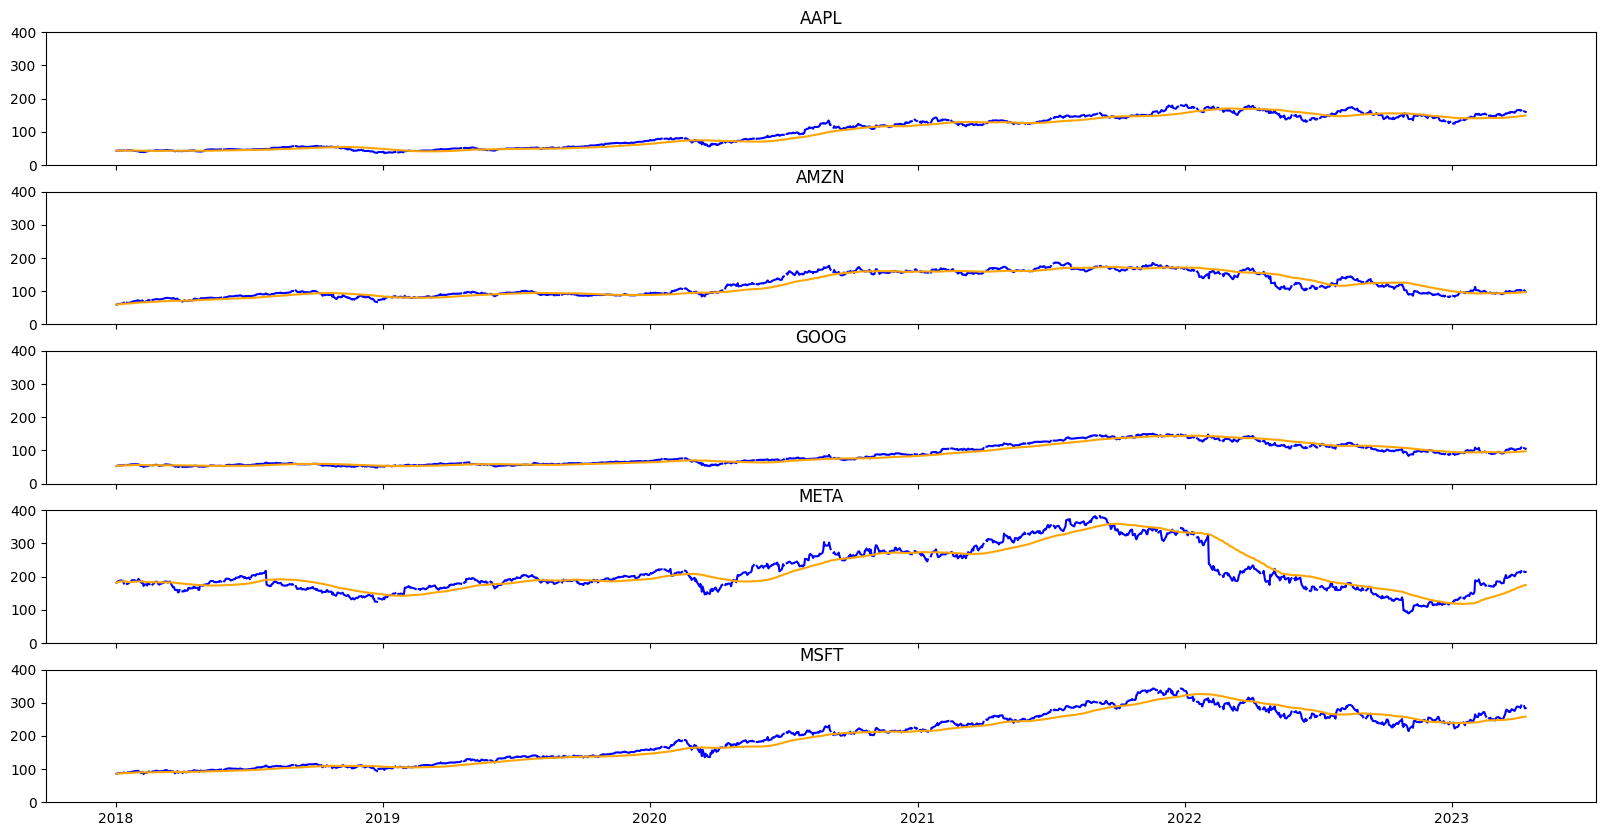

In [8]:
# Add your implementation here.
df = df.loc['2018-01-01':]

fig, axes = plt.subplots(len(df.columns.levels[0]), 1, figsize=(20, 10), sharex=True, sharey=True)

for i, company in enumerate(df.columns.levels[0]):
    ax = axes[i]
    ax.plot(df.index, df[company]['Close'], color='blue', label='Share Price')
    ax.plot(df.index, df[company]['Close'].rolling("100D").mean(), color='orange')
    ax.set_ylim([0, 400])
    ax.set_title(company)

plt.show()

## Task 3

Display volume of traded shares of all companies as a *stacked bar chart*, grouped by decade (1970s, 1980s, 1990s, 2000s, 2010s, and 2020s).

Note that the 70s end in December of 1980.

![Task 3](task3.png)

In [36]:
# Add your implementation here.

# Define a dictionary with the decade ranges
decade_ranges = {'1970s': ('1970-01-01', '1979-12-31'),
                 '1980s': ('1980-01-01', '1989-12-31'),
                 '1990s': ('1990-01-01', '1999-12-31'),
                 '2000s': ('2000-01-01', '2009-12-31'),
                 '2010s': ('2010-01-01', '2019-12-31'),
                 '2020s': ('2020-01-01', '2029-12-31')}

# Create a new column with the decade of each date
df['Decade'] = pd.cut(df.index, bins=[pd.Timestamp(decade_ranges['1970s'][0]), pd.Timestamp(decade_ranges['1980s'][0]), pd.Timestamp(decade_ranges['1990s'][0]), pd.Timestamp(decade_ranges['2000s'][0]), pd.Timestamp(decade_ranges['2010s'][0]), pd.Timestamp(decade_ranges['2020s'][0]), pd.Timestamp(decade_ranges['2020s'][1])], labels=['1970s', '1980s', '1990s', '2000s', '2010s', '2020s'])

# Select only the 'Volume' columns
volume_df = df.loc[:, (slice(None), 'Volume')]

# Group by decade and calculate the total volume
volume_by_decade = volume_df.groupby(['Decade']).sum()

# Calculate the total volume for each company across all decades
total_volume_by_company = volume_df.groupby(['ticker']).sum()

# Create a new DataFrame with the percentage of volume traded by each company in each decade
percentage_volume_df = volume_df.groupby(['ticker', 'Decade']).sum() / total_volume_by_company * 100

# Unstack the DataFrame to make each company a column
percentage_volume_by_decade = percentage_volume_df.unstack(level=0)

# Reorder the index of the DataFrame to show all the decades
percentage_volume_by_decade = percentage_volume_by_decade.reindex(['1970s', '1980s', '1990s', '2000s', '2010s', '2020s'])

# Create a stacked bar chart with the percentage values
percentage_volume_by_decade.plot(kind='bar', stacked=True)

# Set the title and labels for the plot
plt.title('Volume of traded shares by decade and company')
plt.xlabel('Decade')
plt.ylabel('Volume traded (% of total)')

# Set the y-axis limits to 0 and 100 to show percentages
plt.ylim(0, 100)

# Show the plot
plt.show()

KeyError: 'ticker'

## Task 4

Display daily change of the *Meta*'s share price since 2020.

Highlight *extreme* changes (more than 5%) in red.

You must hide `xticks` as there are too many days in the chosen range.

[python - How to remove xticks from a plot - Stack Overflow](https://stackoverflow.com/questions/12998430/how-to-remove-xticks-from-a-plot)

[python - Color matplotlib bar chart based on value - Stack Overflow](https://stackoverflow.com/questions/33476401/color-matplotlib-bar-chart-based-on-value)

![Task 4](task4.png)


In [38]:
# Add your implementation here.

df_meta_close = df.loc['META', 'Close']
# Calculate the daily percentage change since the start of 2020
df_meta_change = df_meta_close.pct_change().loc['2020-01-01':]

# Create a new column for the color of each bar based on the magnitude of the percentage change
df_meta_change['Color'] = 'blue'
df_meta_change.loc[abs(df_meta_change['Close']) > 0.05, 'Color'] = 'red'

# Plot the daily percentage change as a bar chart
ax = df_meta_change.plot(kind='bar', y='Close', color=df_meta_change['Color'], figsize=(12, 6), width=1)

# Set the title and labels for the chart
ax.set_title("Daily Percentage Change of Meta's Share Price Since 2020", fontsize=18)
ax.set_ylabel('Percentage Change', fontsize=14)

# Set the y-axis limits to -10% and 10%
ax.set_ylim(-0.1, 0.1)

# Hide the x-axis tick labels
ax.set_xticklabels([])

# Add a horizontal line at 0%
ax.axhline(y=0, color='gray', linestyle='--')

# Add annotations for extreme changes
for index, row in df_meta_change.iterrows():
    if abs(row['Close']) > 0.05:
        ax.annotate(f"{row['Close']:.2%}", xy=(index, row['Close']), ha='center', va='bottom', fontsize=10)

# Show the plot
plt.show()

KeyError: 'Meta'

## Task 5

Display the share price of *Apple* since 2018.

The figure must contain the 30-days rolling average as a *line*.

The figure must highlight 2023 (starting with 2023-01-01) as a color *below* the rolling average line.

[python - How to plot a rectangle on a datetime axis using matplotlib? - Stack Overflow](https://stackoverflow.com/questions/31162780/how-to-plot-a-rectangle-on-a-datetime-axis-using-matplotlib)

[fill_between(x, y1, y2) — Matplotlib 3.7.1 documentation](https://matplotlib.org/stable/plot_types/basic/fill_between.html)

![Task 5](task5.png)

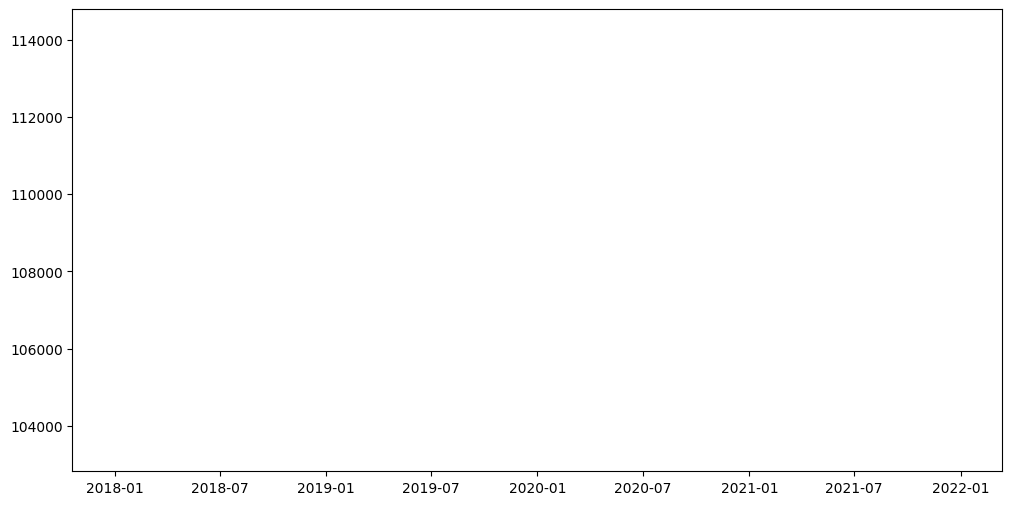

In [32]:
# Add your implementation here.

# Extract the 'AAPL' ticker and the 'Close' property
aapl_close = df[('AAPL', 'Close')].loc['2018':]

# Compute the 30-day rolling average
rolling_avg = aapl_close.rolling('30D').mean()

# Create a plot
fig, ax = plt.subplots(figsize=(12, 6))

# Plot the rolling average
ax.plot(aapl_close, color="orange")
ax.plot(rolling_avg, color="orange")


# Show the plot
plt.show()





## Submission Checklist

- [ ] Your name, today's date, and the assignment title in the designated cell.
- [ ] Your answers in the designated cells (if required).
- [ ] Your code runs and produces the expected output.
- [ ] The validity of your code is verified by autograders (if provided).
- [ ] Restart the kernel and run all cells (in the menubar, select *Kernel*, then *Restart Kernel and Run All Cells*).
- [ ] Save the notebook.
- [ ] Submit the assignment.
